In [2]:
import torch
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# Set the device
device = "mps" if torch.backends.mps.is_available() else "cpu"
print('device:', device)

device: mps


In [2]:
data = pd.read_csv('ready.csv').drop(columns = 'Unnamed: 0')

data['rank'] = data.groupby('year_month')['month_ret'].transform(lambda x: pd.qcut(x, 5, labels = False))
data['Top'] = data['rank'].apply(lambda x: 1 if x == 4 else 0)
data['Bottom'] = data['rank'].apply(lambda x: 1 if x == 0 else 0)
data.drop(columns = 'rank', inplace = True)

data_for_model = data[data['year_month']<'2018']
data

,year_month,PERMNO,RI_Spread,CP_Spread,Skew,chmom,dolvol,Idiovol,indmom,maxret,mom1m,mom12m,mvel1,retvol,month_ret,Top,Bottom
0,1996-02,10078,0.410379,0.665843,0.660771,0.809163,0.923366,0.163088,1.000000,0.304835,0.567332,0.238016,0.063198,0.534237,0.141306,1,0
1,1996-02,10104,0.399722,0.651412,0.705032,0.711171,0.844706,0.096106,0.619444,0.165541,0.701425,0.125665,0.156297,0.302605,0.089004,0,0
2,1996-02,10107,0.395449,0.654715,0.676885,0.689841,0.970092,0.062931,0.619444,0.131657,0.619231,0.113476,0.423907,0.283192,0.066892,0,0
3,1996-02,10138,0.343600,0.637898,0.639781,0.705431,0.426155,0.079755,0.758034,0.247625,0.667062,0.157208,0.009942,0.301626,-0.004630,0,0
4,1996-02,10145,0.371552,0.661506,0.671413,0.722396,0.565909,0.024808,0.676100,0.084367,0.614563,0.099848,0.112486,0.139834,0.119871,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395432,2022-12,93356,0.201888,0.719230,0.265991,0.303625,0.391336,0.004968,0.189687,0.045434,0.246141,0.123820,0.001976,0.058314,-0.097215,0,0
395433,2022-12,93369,0.417082,0.700210,0.265746,0.196569,0.484192,0.028148,0.189687,0.070337,0.019417,0.044460,0.001744,0.275433,0.209944,1,0
395434,2022-12,93374,0.214812,0.745106,0.227228,0.254677,0.442281,0.001835,0.287259,0.040151,0.231290,0.092570,0.002319,0.054230,-0.032653,0,0
395435,2022-12,93423,0.182525,0.714803,0.271413,0.247365,0.489572,0.013803,0.189687,0.060868,0.229787,0.079632,0.000772,0.091424,-0.034867,0,0


# Train With NN3(in > 32 > 16 > 8 > out)
* Label to Predict: Top(1 if in return in month top 20%, else 0), Bottom(1 if in return in month bottom 20%, else 0)
* We Train two models:

1. **topmodel**: using features to predict the probability of the stock being in Top Class
2. **botmodel**: using features to predict the probability of the stock being in Bottom Class

### In Testing Set, We Predict Prababilities of being in Top and Bottom Seperately. 
### Then Calculate the Difference Between two Probabilities.
### Lastly, in each month, we rank the gap and label top 20% as TOP, vice versa.

In [3]:
# 設定隨機種子
np.random.seed(42)
torch.manual_seed(42)

# 將資料分為訓練集和測試集
features = data_for_model.drop(columns=['year_month', 'PERMNO', 'Top', 'Bottom', 'month_ret'])
labels = data_for_model['Top']
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.3, random_state=42)
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)
    
# 將資料轉換為PyTorch張量並移動到指定的設備
train_features = torch.tensor(train_features.values, dtype=torch.float).to(device)
test_features = torch.tensor(test_features.values, dtype=torch.float).to(device)
train_labels = torch.tensor(train_labels.values, dtype=torch.float).to(device)  # Change to float

class mymodel(nn.Module):
    def __init__(self, input_size, output_size, is_training=True):
        super(mymodel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4= nn.Linear(16, 8)
        self.fc5= nn.Linear(8, output_size)
        self.is_training = is_training

    def forward(self, x):
        x = torch.celu(self.fc1(x))
        x = torch.dropout(x, p=0.05, train=self.is_training)
        x = torch.celu(self.fc2(x))
        x = torch.dropout(x, p=0.05, train=self.is_training)
        x = torch.celu(self.fc3(x))
        x = torch.dropout(x, p=0.05, train=self.is_training)
        x = torch.celu(self.fc4(x))
        x = torch.dropout(x, p=0.05, train=self.is_training)
        x = self.fc5(x)  # Return logits
        x = torch.sigmoid(x)  # Apply sigmoid
        return x

# 建立模型並移動到指定的設備
topmodel = mymodel(train_features.shape[1], 1).to(device) 

# 初始化早停相關變數
patience = 200 # 這個數字表示我們要等待多少個epoch沒有改善就停止訓練
stop_early = 0  # 這個數字用來記錄當前已經等待了多少個epoch
best_loss = float('inf')  # 這個數字用來記錄目前最低的loss
n_epoch = 1000  # 這個數字表示我們要訓練多少個epoch

# 定義損失函數和優化器
# weight = torch.tensor(4, dtype=torch.float).to(device)  # Change to a single weight value
# criterion = nn.BCELoss(pos_weight=weight)  # Use pos_weight instead of weight
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(topmodel.parameters(), lr=0.01)

# 訓練模型
for epoch in range(n_epoch):
    optimizer.zero_grad()
    outputs = topmodel(train_features)
    loss = criterion(outputs, train_labels.unsqueeze(1))
    loss.backward()
    optimizer.step() 

    # 如果當前的loss比最低的loss還要低，則更新最低的loss，並重置等待的epoch數
    if loss.item() < best_loss:
        best_loss = loss.item()
        stop_early = 0
    else:
        stop_early += 1

    # 如果等待的epoch數達到了我們設定的patience，則停止訓練
    if stop_early >= patience:
        print('Early stopping at epoch:', epoch)
        break

    print('Epoch [%d/%d], Loss: %.4f' %(epoch+1, n_epoch, loss.item()))

Training Features Shape: (210907, 12)
Training Labels Shape: (210907,)
Testing Features Shape: (90390, 12)
Testing Labels Shape: (90390,)
Epoch [1/1000], Loss: 0.6128
Epoch [2/1000], Loss: 0.5653
Epoch [3/1000], Loss: 0.5329
Epoch [4/1000], Loss: 0.5098
Epoch [5/1000], Loss: 0.5024
Epoch [6/1000], Loss: 0.5126
Epoch [7/1000], Loss: 0.5179
Epoch [8/1000], Loss: 0.5130
Epoch [9/1000], Loss: 0.5055
Epoch [10/1000], Loss: 0.5023
Epoch [11/1000], Loss: 0.5042
Epoch [12/1000], Loss: 0.5076
Epoch [13/1000], Loss: 0.5085
Epoch [14/1000], Loss: 0.5068
Epoch [15/1000], Loss: 0.5042
Epoch [16/1000], Loss: 0.5021
Epoch [17/1000], Loss: 0.5017
Epoch [18/1000], Loss: 0.5023
Epoch [19/1000], Loss: 0.5032
Epoch [20/1000], Loss: 0.5033
Epoch [21/1000], Loss: 0.5027
Epoch [22/1000], Loss: 0.5021
Epoch [23/1000], Loss: 0.5013
Epoch [24/1000], Loss: 0.5006
Epoch [25/1000], Loss: 0.5008
Epoch [26/1000], Loss: 0.5012
Epoch [27/1000], Loss: 0.5016
Epoch [28/1000], Loss: 0.5012
Epoch [29/1000], Loss: 0.5006
E

In [4]:
# 設定隨機種子
np.random.seed(42)
torch.manual_seed(42)

# 將資料分為訓練集和測試集
features = data_for_model.drop(columns=['year_month', 'PERMNO', 'Top', 'Bottom', 'month_ret'])
labels = data_for_model['Bottom']
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.3, random_state=42)
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)
    
# 將資料轉換為PyTorch張量並移動到指定的設備
train_features = torch.tensor(train_features.values, dtype=torch.float).to(device)
test_features = torch.tensor(test_features.values, dtype=torch.float).to(device)
train_labels = torch.tensor(train_labels.values, dtype=torch.float).to(device)  # Change to float

class mymodel(nn.Module):
    def __init__(self, input_size, output_size, is_training=True):
        super(mymodel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4= nn.Linear(16, 8)
        self.fc5= nn.Linear(8, output_size)
        self.is_training = is_training

    def forward(self, x):
        x = torch.celu(self.fc1(x))
        x = torch.dropout(x, p=0.05, train=self.is_training)
        x = torch.celu(self.fc2(x))
        x = torch.dropout(x, p=0.05, train=self.is_training)
        x = torch.celu(self.fc3(x))
        x = torch.dropout(x, p=0.05, train=self.is_training)
        x = torch.celu(self.fc4(x))
        x = torch.dropout(x, p=0.05, train=self.is_training)
        x = self.fc5(x)  # Return logits
        x = torch.sigmoid(x)  # Apply sigmoid
        return x

# 建立模型並移動到指定的設備
botmodel = mymodel(train_features.shape[1], 1).to(device) 

# 初始化早停相關變數
patience = 200 # 這個數字表示我們要等待多少個epoch沒有改善就停止訓練
stop_early = 0  # 這個數字用來記錄當前已經等待了多少個epoch
best_loss = float('inf')  # 這個數字用來記錄目前最低的loss
n_epoch = 1000  # 這個數字表示我們要訓練多少個epoch

# 定義損失函數和優化器
# weight = torch.tensor(4, dtype=torch.float).to(device)  # Change to a single weight value
# criterion = nn.BCELoss(pos_weight=weight)  # Use pos_weight instead of weight
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(botmodel.parameters(), lr=0.01)

# 訓練模型
for epoch in range(n_epoch):
    optimizer.zero_grad()
    outputs = botmodel(train_features)
    loss = criterion(outputs, train_labels.unsqueeze(1))
    loss.backward()
    optimizer.step() 

    # 如果當前的loss比最低的loss還要低，則更新最低的loss，並重置等待的epoch數
    if loss.item() < best_loss:
        best_loss = loss.item()
        stop_early = 0
    else:
        stop_early += 1

    # 如果等待的epoch數達到了我們設定的patience，則停止訓練
    if stop_early >= patience:
        print('Early stopping at epoch:', epoch)
        break

    print('Epoch [%d/%d], Loss: %.4f' %(epoch+1, n_epoch, loss.item()))

Training Features Shape: (210907, 12)
Training Labels Shape: (210907,)
Testing Features Shape: (90390, 12)
Testing Labels Shape: (90390,)
Epoch [1/1000], Loss: 0.6126
Epoch [2/1000], Loss: 0.5649
Epoch [3/1000], Loss: 0.5324
Epoch [4/1000], Loss: 0.5092
Epoch [5/1000], Loss: 0.5019
Epoch [6/1000], Loss: 0.5121
Epoch [7/1000], Loss: 0.5170
Epoch [8/1000], Loss: 0.5122
Epoch [9/1000], Loss: 0.5047
Epoch [10/1000], Loss: 0.5015
Epoch [11/1000], Loss: 0.5032
Epoch [12/1000], Loss: 0.5066
Epoch [13/1000], Loss: 0.5075
Epoch [14/1000], Loss: 0.5057
Epoch [15/1000], Loss: 0.5032
Epoch [16/1000], Loss: 0.5010
Epoch [17/1000], Loss: 0.5002
Epoch [18/1000], Loss: 0.5009
Epoch [19/1000], Loss: 0.5014
Epoch [20/1000], Loss: 0.5018
Epoch [21/1000], Loss: 0.5012
Epoch [22/1000], Loss: 0.5001
Epoch [23/1000], Loss: 0.4988
Epoch [24/1000], Loss: 0.4981
Epoch [25/1000], Loss: 0.4979
Epoch [26/1000], Loss: 0.4986
Epoch [27/1000], Loss: 0.4985
Epoch [28/1000], Loss: 0.4973
Epoch [29/1000], Loss: 0.4961
E

# Model Evaluation on Validation Set

In [5]:
# 測試 Top&Bot 模型
topmodel.eval()
botmodel.eval()
topmodel.is_training = False
botmodel.is_training = False
    
with torch.no_grad():
    topoutputs = (topmodel(test_features))
    botoutputs = (botmodel(test_features))

# 創建一個新的 DataFrame 包含測試集的 'year_month', 'PERMNO', 'month_ret', 'month_exret', 'Top', 'Bottom' 列
test_df = data_for_model.loc[test_labels.index, ['year_month', 'PERMNO', 'month_ret', 'Top', 'Bottom']]

# 將預測概率添加到新的 'Top_prob_pred' 列
test_df['Top_prob_pred'] = topoutputs.cpu().numpy()
test_df['Bot_prob_pred'] = botoutputs.cpu().numpy()

test_df.sort_values(['year_month', 'PERMNO'], ascending=[True, True], inplace=True)
test_df['tmb'] = test_df['Top_prob_pred'] - test_df['Bot_prob_pred']

# 每個月份中預測概率最高的20%的樣本分類為1
test_df['top_preds'] = test_df.groupby('year_month')['tmb'].transform(lambda x: x >= x.quantile(0.8)).astype(int)
test_df['bot_preds'] = test_df.groupby('year_month')['tmb'].transform(lambda x: x <= x.quantile(0.2)).astype(int)

# 計算準確率
topaccuracy = accuracy_score(test_df['Top'], test_df['top_preds'])
botaccuracy = accuracy_score(test_df['Bottom'], test_df['bot_preds'])
print('Top Model accuracy:', topaccuracy)
print('Bot Model accuracy:', botaccuracy)

Top Model accuracy: 0.6761809934727293
Bot Model accuracy: 0.7136408894789247


In [7]:
data_for_backtest = data[data['year_month']>='2018'].copy().reset_index(drop = True)

features = data_for_backtest.drop(columns=['year_month', 'PERMNO', 'month_ret', 'Top', 'Bottom'])
print('Features Shape:', features.shape)

topmodel.eval()
botmodel.eval()
topmodel.is_training = False
botmodel.is_training = False
with torch.no_grad():
    bt_top_prob = (topmodel(torch.tensor(features.values, dtype=torch.float).to(device)))
    bt_bot_prob = (botmodel(torch.tensor(features.values, dtype=torch.float).to(device)))

bt_top_prob = bt_top_prob.cpu().numpy()
bt_bot_prob = bt_bot_prob.cpu().numpy()

data_for_backtest.loc[:, 'Top_prob_pred'] = bt_top_prob
data_for_backtest.loc[:, 'Bot_prob_pred'] = bt_bot_prob

data_for_backtest.sort_values(['year_month', 'PERMNO'], ascending=[True, True], inplace=True)
data_for_backtest['tmb'] = data_for_backtest['Top_prob_pred'] - data_for_backtest['Bot_prob_pred']

df = data_for_backtest[['year_month', 'PERMNO', 'month_ret', 'Top_prob_pred', 'Bot_prob_pred', 'tmb']]
df.to_csv('NN3_2models.csv')
display(df)

Features Shape: (94140, 12)


,year_month,PERMNO,month_ret,Top_prob_pred,Bot_prob_pred,tmb
0,2018-01,10032,-0.015973,0.190150,0.198881,-0.008731
1,2018-01,10104,0.095383,0.140625,0.100642,0.039983
2,2018-01,10107,0.110706,0.124439,0.113083,0.011356
3,2018-01,10138,0.063854,0.146380,0.106009,0.040371
4,2018-01,10145,0.041145,0.121677,0.085234,0.036443
...,...,...,...,...,...,...
94135,2022-12,93356,-0.097215,0.199619,0.226535,-0.026917
94136,2022-12,93369,0.209944,0.253209,0.329542,-0.076333
94137,2022-12,93374,-0.032653,0.197232,0.217309,-0.020077
94138,2022-12,93423,-0.034867,0.268375,0.297036,-0.028661


# Training with XGB Model

In [18]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

train_features = data_for_model.drop(columns=['year_month', 'PERMNO', 'month_ret', 'Top', 'Bottom'])
train_labels_top = data_for_model['Top']
train_labels_bot = data_for_model['Bottom']
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels_top.shape)
print('Training Labels Shape:', train_labels_bot.shape)

data_for_backtest = data[data['year_month']>='2018'].copy().reset_index(drop = True)
test_features = data_for_backtest.drop(columns=['year_month', 'PERMNO', 'month_ret', 'Top', 'Bottom'])
test_labels_top = data_for_backtest['Top']
test_labels_bot = data_for_backtest['Bottom']

topmodel_xgb = xgb.XGBClassifier(objective='binary:logistic', random_state=42, n_jobs=-1,
                                 max_depth=6, colsample_bytree = 0.6, subsample = 0.5, n_estimators=50, learning_rate=0.1)

botmodel_xgb = xgb.XGBClassifier(objective='binary:logistic', random_state=42, n_jobs=-1,
                                 max_depth=6, colsample_bytree = 0.6, subsample = 0.5, n_estimators=50, learning_rate=0.1)

topmodel_xgb.fit(train_features, train_labels_top)

botmodel_xgb.fit(train_features, train_labels_bot)

prob_top = topmodel_xgb.predict_proba(test_features)[:,1]
prob_bot = botmodel_xgb.predict_proba(test_features)[:,1]

data_for_backtest.loc[:, 'Top_prob_pred'] = prob_top
data_for_backtest.loc[:, 'Bot_prob_pred'] = prob_bot

data_for_backtest.sort_values(['year_month', 'PERMNO'], ascending=[True, True], inplace=True)
data_for_backtest['tmb'] = data_for_backtest['Top_prob_pred'] - data_for_backtest['Bot_prob_pred']

df = data_for_backtest[['year_month', 'PERMNO', 'month_ret', 'Top_prob_pred', 'Bot_prob_pred', 'tmb']]
df.to_csv('XGB_2models.csv')
display(df)

Training Features Shape: (301297, 12)
Training Labels Shape: (301297,)
Training Labels Shape: (301297,)


,year_month,PERMNO,month_ret,Top_prob_pred,Bot_prob_pred,tmb
0,2018-01,10032,-0.015973,0.164782,0.195004,-0.030222
1,2018-01,10104,0.095383,0.145055,0.114799,0.030256
2,2018-01,10107,0.110706,0.149530,0.105556,0.043974
3,2018-01,10138,0.063854,0.136124,0.103966,0.032158
4,2018-01,10145,0.041145,0.076845,0.079190,-0.002346
...,...,...,...,...,...,...
94135,2022-12,93356,-0.097215,0.197332,0.188878,0.008455
94136,2022-12,93369,0.209944,0.281536,0.312693,-0.031157
94137,2022-12,93374,-0.032653,0.167683,0.168578,-0.000896
94138,2022-12,93423,-0.034867,0.237794,0.268822,-0.031028


# Training with LGBM Model

In [19]:
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

train_features = data_for_model.drop(columns=['year_month', 'PERMNO', 'month_ret', 'Top', 'Bottom'])
train_labels_top = data_for_model['Top'] 
train_labels_bot = data_for_model['Bottom']

data_for_backtest = data[data['year_month']>='2018'].copy().reset_index(drop = True)
test_features = data_for_backtest.drop(columns=['year_month', 'PERMNO', 'month_ret', 'Top', 'Bottom'])
test_labels_top = data_for_backtest['Top']
test_labels_bot = data_for_backtest['Bottom']

topmodel_lgbm = lgb.LGBMClassifier(objective='binary', random_state=42, n_jobs=-1, verbose = -1, 
                                   max_depth=6, num_leaves = 5, n_estimators = 50, colsample_bytree = 0.4, learning_rate = 0.1)

topmodel_lgbm.fit(train_features, train_labels_top)

botmodel_lgbm = lgb.LGBMClassifier(objective='binary', random_state=42, n_jobs=-1, verbose = -1, 
                                   max_depth=6, num_leaves = 5, n_estimators = 50, colsample_bytree = 0.4, learning_rate = 0.1)

botmodel_lgbm.fit(train_features, train_labels_bot)

prob_top = topmodel_lgbm.predict_proba(test_features)[:,1]
prob_bot = botmodel_lgbm.predict_proba(test_features)[:,1]

data_for_backtest.loc[:, 'Top_prob_pred'] = prob_top
data_for_backtest.loc[:, 'Bot_prob_pred'] = prob_bot

data_for_backtest.sort_values(['year_month', 'PERMNO'], ascending=[True, True], inplace=True)
data_for_backtest['tmb'] = data_for_backtest['Top_prob_pred'] - data_for_backtest['Bot_prob_pred']

df = data_for_backtest[['year_month', 'PERMNO', 'month_ret', 'Top_prob_pred', 'Bot_prob_pred', 'tmb']]
df.to_csv('LGBM_2models.csv')
display(df)

,year_month,PERMNO,month_ret,Top_prob_pred,Bot_prob_pred,tmb
0,2018-01,10032,-0.015973,0.178392,0.187845,-0.009453
1,2018-01,10104,0.095383,0.142135,0.124916,0.017219
2,2018-01,10107,0.110706,0.118847,0.100519,0.018328
3,2018-01,10138,0.063854,0.134171,0.117057,0.017113
4,2018-01,10145,0.041145,0.090658,0.091236,-0.000577
...,...,...,...,...,...,...
94135,2022-12,93356,-0.097215,0.193167,0.185288,0.007879
94136,2022-12,93369,0.209944,0.263014,0.266874,-0.003860
94137,2022-12,93374,-0.032653,0.151316,0.161498,-0.010182
94138,2022-12,93423,-0.034867,0.224544,0.230850,-0.006307


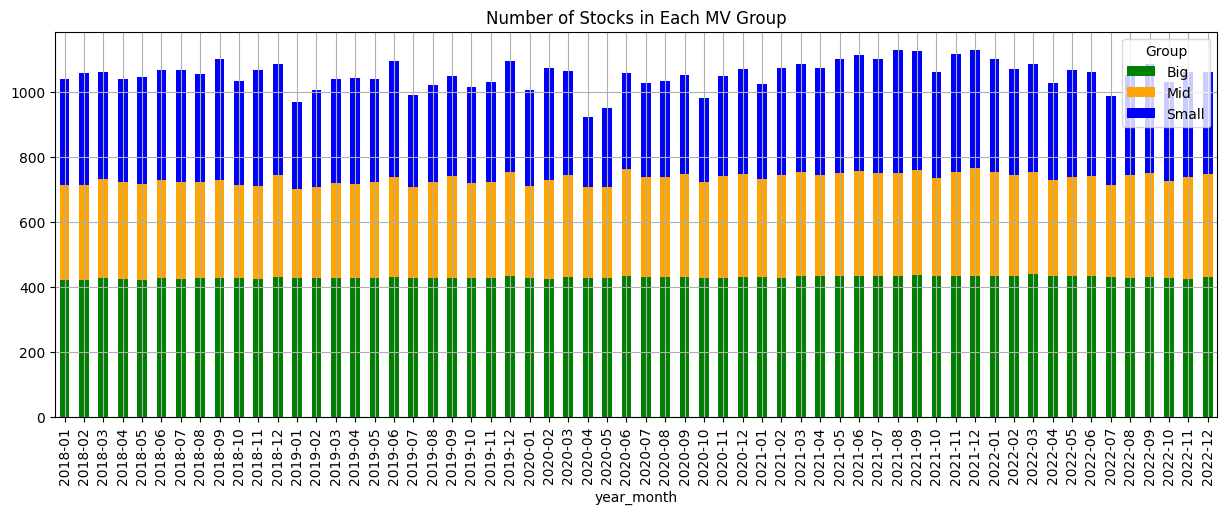

In [5]:
data = pd.read_csv('ready.csv').drop(columns = 'Unnamed: 0')
crsp = pd.read_pickle('/Users/leeyuehsin_macmini/Desktop/論文/1. 資料整理/2. CRSP資料整理/CRSP.pickle')
ETFs = pd.read_csv('ETFs.csv')

data_for_backtest = data[data['year_month']>='2018'].copy().reset_index(drop = True)
OOS_Permno = data_for_backtest[['year_month', 'PERMNO', 'month_ret']].copy()
PERMNO_CUSIP_Map = crsp[['PERMNO', 'CUSIP']].drop_duplicates().reset_index(drop = True)
ETFs['CUSIP'] = ETFs['CUSIP'].str[:-1]

OOS_Permno = pd.merge(OOS_Permno, PERMNO_CUSIP_Map, on = 'PERMNO', how = 'left')
df = pd.merge(OOS_Permno, ETFs, on = ['CUSIP', 'year_month'], how = 'inner')

df['year_month'] = pd.to_datetime(df['year_month'], format = '%Y-%m')
df['year_month'] = df['year_month'].dt.to_period('M')

mv = pd.read_pickle('mvel1.pickle')
df = pd.merge(df, mv, on = ['year_month', 'PERMNO'], how = 'inner')

colors = {'Big':'green', 'Mid':'orange', 'Small':'blue'}
df.groupby(['year_month', 'Group']).apply(lambda x: x['PERMNO'].nunique()).unstack().plot(kind = 'bar', stacked = True, figsize = (15, 5), color = colors)
plt.title('Number of Stocks in Each MV Group')
plt.grid(True)
plt.show()

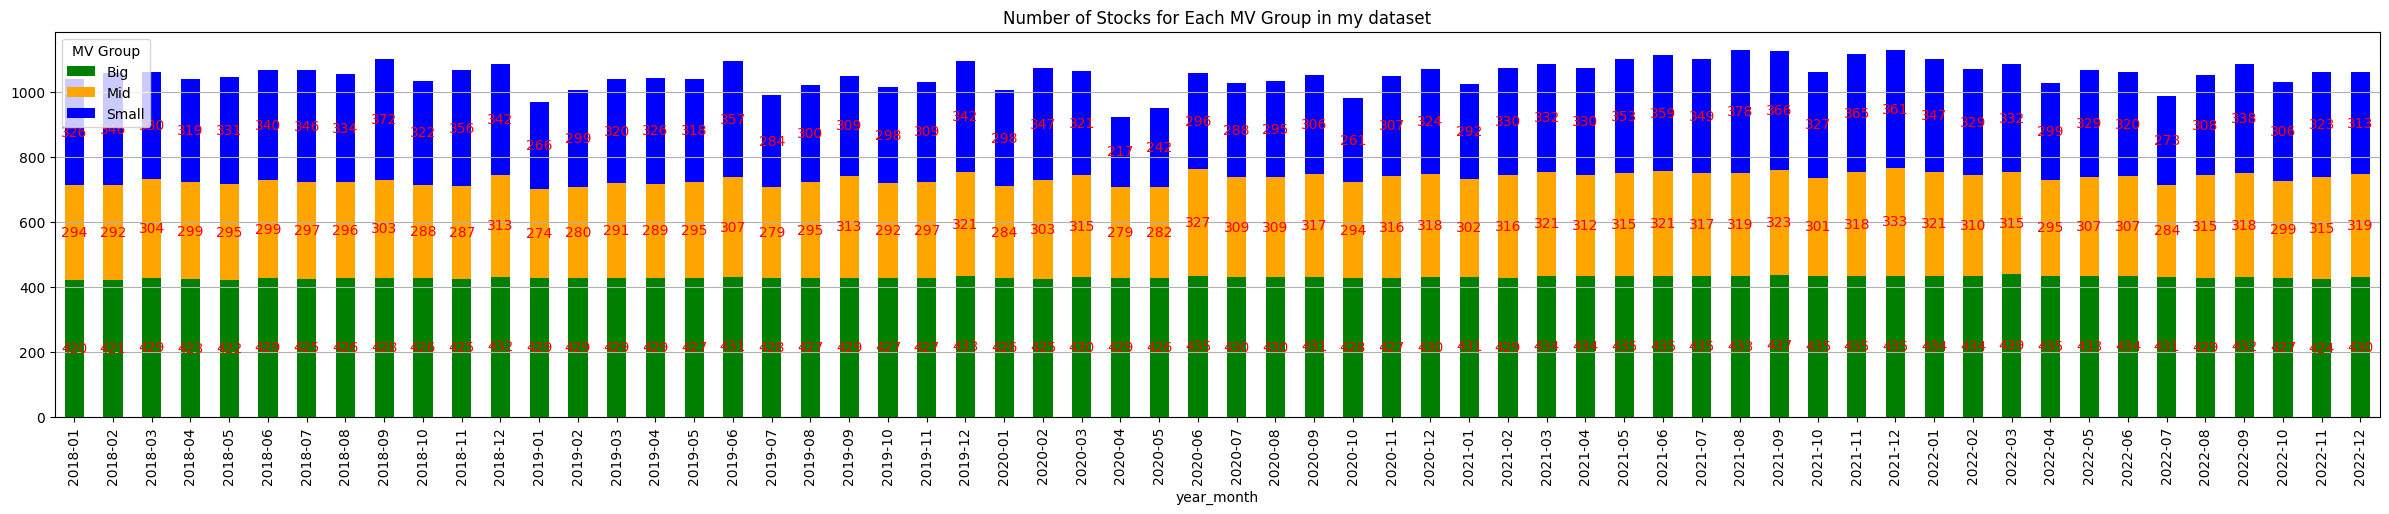

In [26]:
colors = {'Big':'green', 'Mid':'orange', 'Small':'blue'}
grouped = df.groupby(['year_month', 'Group']).apply(lambda x: x['PERMNO'].nunique()).unstack()
ax = grouped.plot(kind = 'bar', stacked = True, figsize = (30, 5), color = colors)

# Add numbers on the bars
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.0f}'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center',
            fontsize = 10, color = 'red')

plt.title('Number of Stocks for Each MV Group in my dataset')
plt.legend(title = 'MV Group', loc = 'upper left')
plt.grid(axis = 'y')
plt.show()

[*********************100%%**********************]  3 of 3 completed


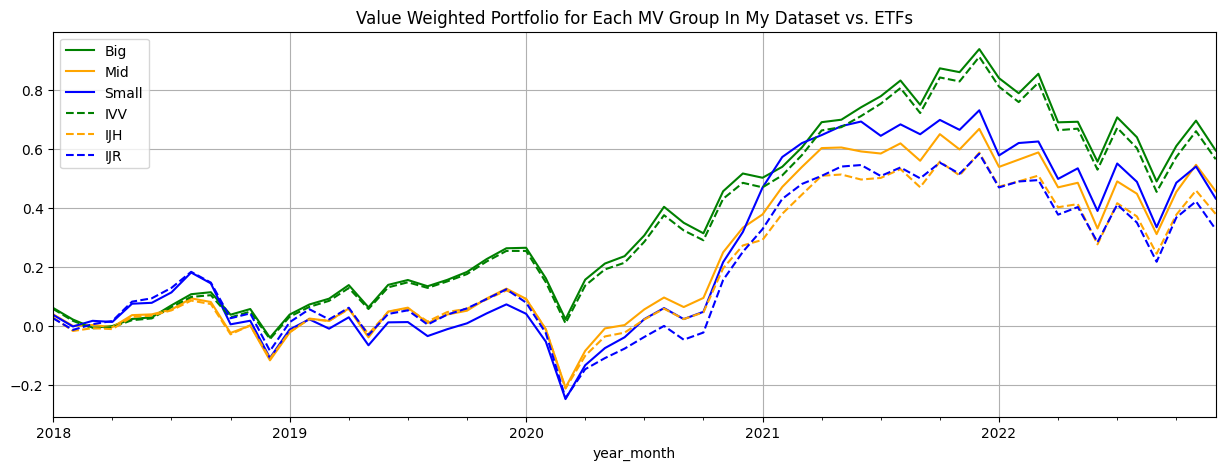

In [15]:
import matplotlib.pyplot as plt
import yfinance as yf

tickers = ['IVV', 'IJH', 'IJR']
start = '2017-12-01'
end = '2022-12-31'

ETF = yf.download(tickers, start=start, end=end)['Adj Close']
ETF = ETF.resample('M').last()
ETF_ret = ETF.pct_change().dropna()
ETF_ret.index.rename('year_month', inplace = True)
ETF_ret.index = ETF_ret.index.to_period('M')
ETF_ret+=1
ret = df.groupby(['year_month', 'Group']).apply(lambda x : np.average(x['month_ret'], weights = x['stockmv'])).unstack()+1

ret_vs_ETF = pd.concat([ETF_ret, ret], axis = 1).cumprod()-1

plt.figure(figsize=(15, 5))

# 繪製實心線
ret_vs_ETF['Big'].plot(color='green', label='Big')
ret_vs_ETF['Mid'].plot(color='orange', label='Mid')
ret_vs_ETF['Small'].plot(color='blue', label='Small')

# 繪製虛線
ret_vs_ETF['IVV'].plot(color='green', linestyle='dashed', label='IVV')
ret_vs_ETF['IJH'].plot(color='orange', linestyle='dashed', label='IJH')
ret_vs_ETF['IJR'].plot(color='blue', linestyle='dashed', label='IJR')

plt.title('Value Weighted Portfolio for Each MV Group In My Dataset vs. ETFs')
plt.grid(True)
plt.legend()  # 顯示圖例
plt.show()  # 顯示圖表